# Import Libraries

In [1]:
import sys
print(sys.executable)

G:\My Drive\D-VA\Load Forecasting\venv\Scripts\python.exe


In [2]:
import optuna

G:\My Drive\D-VA\Load Forecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna


OSError: [WinError 126] The specified module could not be found. Error loading "G:\My Drive\D-VA\Load Forecasting\venv\Lib\site-packages\torch\lib\torch_python.dll" or one of its dependencies.

In [ ]:
import optuna

# Load and Preprocess dataset

In [25]:
df = pd.read_csv('normally_generated_seasoned_data.csv')
df = pd.DataFrame(df['Power'])
df

,Power
0,792
1,733
2,706
3,684
4,784
...,...
26179,1122
26180,1131
26181,953
26182,762


**Scaling**

In [26]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Power'])
df

,Power
0,-0.194168
1,-0.205339
2,-0.210452
3,-0.214617
4,-0.195683
...,...
26179,-0.131686
26180,-0.129982
26181,-0.163685
26182,-0.199849


# Separate train and test data

In [27]:
training_data_len = int(len(df)*0.8)
validation_data_len = int(len(df)*0.1)
print(training_data_len)
print(validation_data_len)

train_data = df[:training_data_len]
validation_data = df[training_data_len:training_data_len+validation_data_len]
test_data = df[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

20947
2618
(20947, 1) (2618, 1) (2619, 1)


In [28]:
print(train_data['Power'].mean())
print(validation_data['Power'].mean())
print(test_data['Power'].mean())

-0.12010881919923394
-0.12347053406578602
-0.12146799560461911


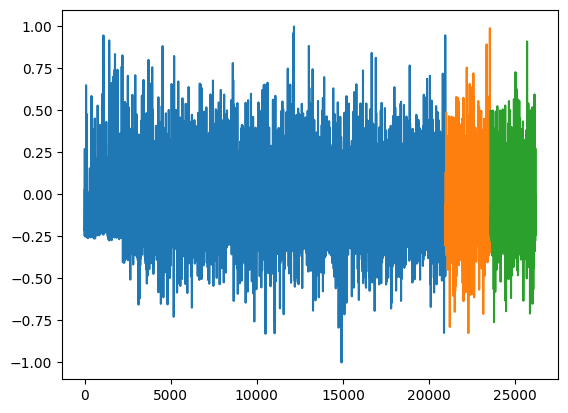

In [29]:
plt.plot(train_data['Power'])
plt.plot(validation_data['Power'])
plt.plot(test_data['Power'])
plt.show()

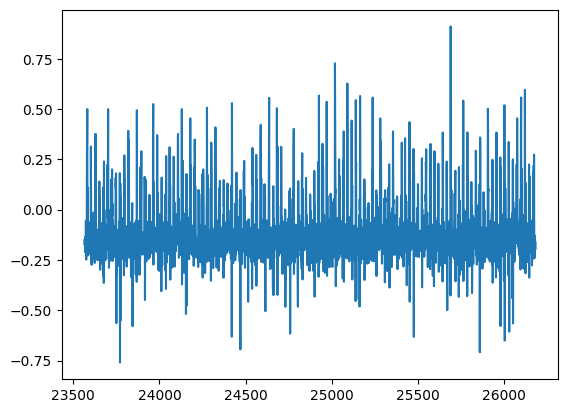

In [30]:
plt.plot(test_data['Power'])
plt.show()

In [31]:
dataset_train = train_data['Power'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(20947, 1)

In [32]:
dataset_validation = validation_data['Power'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
dataset_validation.shape

(2618, 1)

In [33]:
dataset_test = test_data['Power'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(2619, 1)

**Create Sequences**

In [34]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [35]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((20923, 24, 1), (20923, 24, 1))

In [36]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_validation.shape, y_validation.shape

((2594, 24, 1), (2594, 24, 1))

In [37]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((2595, 24, 1), (2595, 24, 1))

**Convert to Tensors**

In [38]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([20923, 24, 1]) torch.Size([20923, 24, 1])
torch.Size([2594, 24, 1]) torch.Size([2594, 24, 1])
torch.Size([2595, 24, 1]) torch.Size([2595, 24, 1])


# Create Model

In [39]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, drop_out):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=drop_out)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Automated Hyperparameter Tuning

In [41]:
def objective(trial):
    input_size = 1

    # Hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    num_layers = 2  #trial.suggest_int('num_layers', 2, 3)
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    drop_out = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.8)

    # Create the model
    model = LSTM(input_size, hidden_size, num_layers, drop_out)
    print(type(model))
    model = model.to(device)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RAdam"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    batch_size = 32 # trial.suggest_categorical('batch_size', [16, 32, 64])
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

    validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    num_epochs = 50 #trial.suggest_int('num_epochs', 10, 60)
    train_loss_hist =[]
    validation_loss_hist =[]
    train_mape_hist = []
    validation_mape_hist = []
    # Training loop
    for epoch in range(num_epochs):
      total_loss_train = 0.0
      total_mape_train = 0.0

      # Training
      model.train()
      for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        # predictions = predictions[:, -1, :]
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

      # Calculate average training loss and accuracy
      average_loss_train = total_loss_train / len(train_loader)
      train_loss_hist.append(average_loss_train)
      average_mape_train = total_mape_train / len(train_loader)
      train_mape_hist.append(average_mape_train)

      # Validation on test data
      model.eval()
      with torch.no_grad():
        total_loss_validation = 0.0
        total_mape_validation = 0.0

        for batch_X_validation, batch_y_validation in validation_loader:
          batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
          predictions_validation = model(batch_X_validation).to(device)
          # predictions_validation = predictions_validation[:, -1, :]
          validation_loss = loss_fn(predictions_validation, batch_y_validation)

          total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
          total_loss_validation += validation_loss.item()

        # Calculate average test loss and accuracy
        average_loss_validation = total_loss_validation / len(validation_loader)
        average_loss_validation = average_loss_validation
        validation_loss_hist.append(average_loss_validation)
        average_mape_validation = total_mape_validation / len(validation_loader)
        validation_mape_hist.append(average_mape_validation)
      # if (epoch+1)%10==0:
      #   print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')

      trial.report(average_loss_validation, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return average_loss_validation


In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-30 09:46:54,351] A new study created in memory with name: no-name-8ea42e43-db6e-4c94-9054-56d36ec75350


<class '__main__.LSTM'>


[I 2024-07-30 09:48:27,635] Trial 0 finished with value: 0.02781319017408461 and parameters: {'hidden_size': 87, 'lr': 0.0005799329613970483, 'dropout_l2594': 0.25676397827641645}. Best is trial 0 with value: 0.02781319017408461.


<class '__main__.LSTM'>


[I 2024-07-30 09:50:01,094] Trial 1 finished with value: 0.026167593691952346 and parameters: {'hidden_size': 59, 'lr': 0.005447603885130112, 'dropout_l2594': 0.18399734686215155}. Best is trial 1 with value: 0.026167593691952346.


<class '__main__.LSTM'>


[I 2024-07-30 09:51:34,185] Trial 2 finished with value: 0.023931960382203504 and parameters: {'hidden_size': 34, 'lr': 0.009070317714333337, 'dropout_l2594': 0.48057048444629286}. Best is trial 2 with value: 0.023931960382203504.


<class '__main__.LSTM'>


[I 2024-07-30 09:53:07,369] Trial 3 finished with value: 0.025403637041496795 and parameters: {'hidden_size': 82, 'lr': 0.0011526868401491265, 'dropout_l2594': 0.7327987261415093}. Best is trial 2 with value: 0.023931960382203504.


<class '__main__.LSTM'>


[I 2024-07-30 09:54:40,281] Trial 4 finished with value: 0.024170132160822793 and parameters: {'hidden_size': 39, 'lr': 0.004833088883294578, 'dropout_l2594': 0.667625593098523}. Best is trial 2 with value: 0.023931960382203504.


<class '__main__.LSTM'>


[I 2024-07-30 09:56:13,821] Trial 5 finished with value: 0.025453194782773896 and parameters: {'hidden_size': 126, 'lr': 0.0033137288747206845, 'dropout_l2594': 0.7544220224897632}. Best is trial 2 with value: 0.023931960382203504.


<class '__main__.LSTM'>


[I 2024-07-30 09:56:15,708] Trial 6 pruned. 


<class '__main__.LSTM'>


[I 2024-07-30 09:56:18,085] Trial 7 pruned. 


<class '__main__.LSTM'>


[I 2024-07-30 09:56:19,934] Trial 8 pruned. 


<class '__main__.LSTM'>


[I 2024-07-30 09:57:52,862] Trial 9 finished with value: 0.02521909018069869 and parameters: {'hidden_size': 53, 'lr': 0.005796048789023006, 'dropout_l2594': 0.46675995540841103}. Best is trial 2 with value: 0.023931960382203504.


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  3
  Number of complete trials:  7
Best trial:
  Value:  0.023931960382203504
  Params: 
    hidden_size: 34
    lr: 0.009070317714333337
    dropout_l2594: 0.48057048444629286


In [43]:
optuna.visualization.plot_optimization_history(study)

In [44]:
optuna.visualization.plot_param_importances(study)

In [45]:
optuna.visualization.plot_slice(study)

In [46]:
optuna.visualization.plot_contour(study)

In [47]:
optuna.visualization.plot_parallel_coordinate(study)

**Torch Dataloader**

In [48]:
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [49]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([16, 24, 1]), y shape: torch.Size([16, 24, 1])


# Train the Model

In [50]:
num_epochs = 40
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# predictions = predictions[:, -1, :]
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


NameError: name 'model' is not defined

In [ ]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Validation MAPE: {validation_mape_hist[i]:.2f}')

In [ ]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

In [ ]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.title("Training and Validation MAPE")
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.legend()
plt.show()

# Evaluate on Test Data

In [ ]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions = model(batch_X_test)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])


In [ ]:
# MAPE on test data
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

In [ ]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

In [ ]:
# plot actual vs predicted powers on first test data
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_original[:100], label='Predicted Power')
plt.plot(actuals_test_original[:100], label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Training Data

In [ ]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])


In [ ]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

In [ ]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_train_original[:100], label='Predicted Power', linewidth=1)
plt.plot(actuals_train_original[:100], label='Actual Power', linewidth=1)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-Evaluate on Validation Data

In [ ]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy()[:, :]
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy()[:, :]
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [ ]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

In [ ]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

In [ ]:
# plot on first 100 validation data
plt.figure(figsize=(10, 6))
plt.plot(predictions_validation_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_validation_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()